In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

## Docking distributions

In [2]:
model = []
molecule = []
iteration = []
annotation = []
docking = []
seed = []
for fn in sorted(os.listdir("tmp/16")):
    if not fn.startswith("docking") or not fn.endswith(".csv") or "biased" in fn:
        continue
    if "rbm" not in fn and "random" not in fn:
        continue
    if "lower_similarity" not in fn:
        continue
    if "kaiming" not in fn:
        continue
    pieces = fn.split("_")
    df = pd.read_csv(f"tmp/16/{fn}")
    if "scores" not in df.columns:
        continue
    print(fn)
    for score in df.scores.values:
        iteration.append(int(pieces[1]))
        model.append(pieces[2])
        molecule.append(pieces[3])
        
        ann_label = "low sim. threshold" if "lower_similarity" in fn else "high sim. threshold"
        if "limited" in fn:
            ann_label += " | limited dataset"
        if "costhyperparams" in fn:
            ann_label += " | cost hyperparams"
        if "different_random_seed" in fn:
            ann_label += " | different random seed"
            random_seed = fn.split("different_random_seed")[1]
            if "_" in random_seed:
                random_seed = int(random_seed.split("_")[1].split(".")[0])
            else:
                random_seed = -1
                # print("NO RANDOM SEED, ASSIGNED -1")
        else:
            random_seed = -2
            # print("NO RANDOM SEED, ASSIGNED -2")
        seed.append(random_seed)
        annotation.append(ann_label)
        docking.append(score)

df_docking = pd.DataFrame({"model": model, "molecule": molecule, "iteration": iteration, "annotation": annotation, "docking": docking, "seed": seed})

docking_0_rbm_1syh_60_lower_similarity_kaiming_seed_3254176.csv
docking_1_rbm_1syh_60_lower_similarity_kaiming_seed_3254176.csv
docking_2_rbm_1syh_60_lower_similarity_kaiming_seed_3254176.csv
docking_3_rbm_1syh_60_lower_similarity_kaiming_seed_3254176.csv
docking_4_rbm_1syh_60_lower_similarity_kaiming_seed_3254176.csv
docking_5_rbm_1syh_60_lower_similarity_kaiming_seed_3254176.csv
docking_6_rbm_1syh_60_lower_similarity_kaiming_seed_3254176.csv
docking_7_rbm_1syh_60_lower_similarity_kaiming_seed_3254176.csv
docking_8_rbm_1syh_60_lower_similarity_kaiming_seed_3254176.csv
docking_9_rbm_1syh_60_lower_similarity_kaiming_seed_3254176.csv


In [3]:
df_docking_min = df_docking.groupby(["model", "molecule", "iteration", "seed"]).min().reset_index()
df_docking_min = df_docking_min.sort_values(by=["model", "iteration", "seed"])

In [4]:
df_docking_min

,model,molecule,iteration,seed,annotation,docking
0,rbm,1syh,0,-2,low sim. threshold,-10.3
1,rbm,1syh,1,-2,low sim. threshold,-10.6
2,rbm,1syh,2,-2,low sim. threshold,-11.2
3,rbm,1syh,3,-2,low sim. threshold,-12.0
4,rbm,1syh,4,-2,low sim. threshold,-12.8
5,rbm,1syh,5,-2,low sim. threshold,-12.8
6,rbm,1syh,6,-2,low sim. threshold,-13.1
7,rbm,1syh,7,-2,low sim. threshold,-13.1
8,rbm,1syh,8,-2,low sim. threshold,-13.1
9,rbm,1syh,9,-2,low sim. threshold,-13.1


In [5]:
df_docking_min[(df_docking_min.model=="random")&(df_docking_min.iteration==1)]

,model,molecule,iteration,seed,annotation,docking


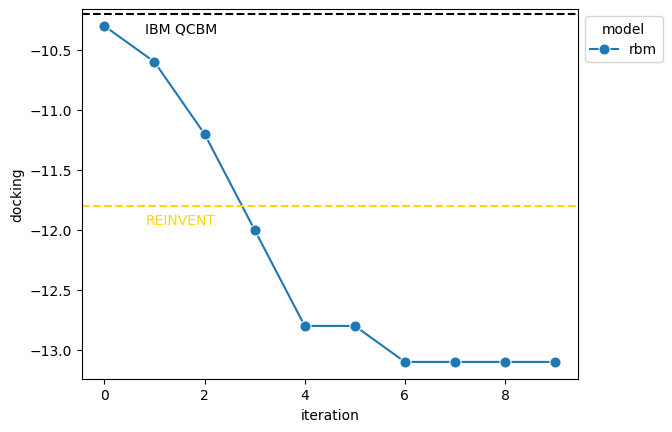

In [6]:
fig, ax = plt.subplots()
sns.lineplot(data=df_docking_min[df_docking_min.molecule == "1syh"], x="iteration", y="docking", hue="model", markers=True, dashes=False, ax=ax, markersize=8, marker="o")
ax.axhline(-10.2, color="black", ls="--")
# Text on axhline:
ax.text(0.2, -10.32, "IBM QCBM", horizontalalignment='center', verticalalignment='center', transform=ax.get_yaxis_transform(), color="black")
ax.axhline(-11.8, color="gold", ls="--")
ax.text(0.2, -11.92, "REINVENT", horizontalalignment='center', verticalalignment='center', transform=ax.get_yaxis_transform(), color="gold")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

In [7]:
!pip install NonParStat

In [8]:
# Smirnov test between random and rbm at each iteration
from scipy.stats import ks_2samp, ttest_ind
from nonparstat.Cucconi import cucconi_test

iterations = []
p_values = []
ks_values = []
cp_values = []
c_values = []
tp_values = []
t_values = []
for iteration in df_docking_min[df_docking_min.molecule == "1syh"].iteration.unique():
    df_iteration = df_docking_min[df_docking_min.iteration == iteration]
    df_random = df_iteration[df_iteration.model == "random"]
    df_rbm = df_iteration[df_iteration.model == "rbm"]
    ks, p = ks_2samp(df_random.docking, df_rbm.docking, alternative="less")
    cuc, pc = cucconi_test(df_random.docking, df_rbm.docking)
    t, tp = ttest_ind(df_random.docking, df_rbm.docking, equal_var=False, alternative="less")
    iterations.append(iteration)
    p_values.append(p)
    ks_values.append(ks)
    cp_values.append(pc)
    c_values.append(cuc)
    tp_values.append(tp)
    t_values.append(t)
df_ks = pd.DataFrame({"iteration": iterations, "p_value": p_values, "ks_value": ks_values, "cucconi_p_value": cp_values, "cucconi_value": c_values, "t_value": t_values, "t_p_value": tp_values})

df_ks


ValueError: Data passed to ks_2samp must not be empty

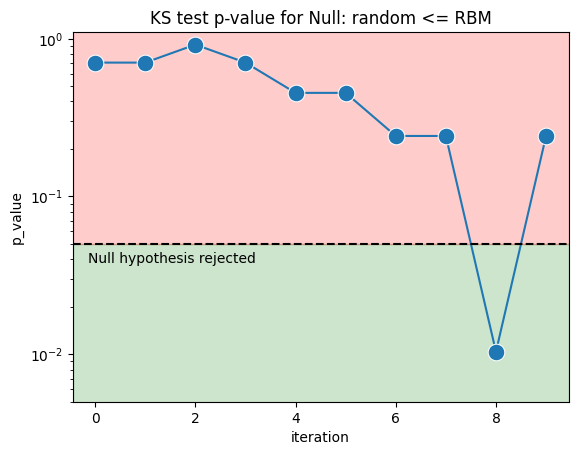

In [ ]:
fig, ax = plt.subplots()
sns.lineplot(data=df_ks, x="iteration", y="p_value", markers=True, dashes=False, ax=ax, markersize=12, marker="o")
ax.axhline(0.05, color="black", ls="--")

# Draw a filled area below the 0.05 line without modifying the original plot's limits:
original_xlim = ax.get_xlim()
original_ylim = ax.get_ylim()
ax.fill_between(original_xlim, 0, 0.05, color="green", alpha=0.2)
ax.fill_between(original_xlim, 0.05, 10, color="red", alpha=0.2)
ax.set_xlim(original_xlim)
ax.set_ylim((0.005, 1.1))

# Text below 0.05 line saying that the null hypothesis is rejected:
ax.text(0.2, 0.04, "Null hypothesis rejected", horizontalalignment='center', verticalalignment='center', transform=ax.get_yaxis_transform(), color="black")
ax.set_yscale("log")
ax.set_title("KS test p-value for Null: random <= RBM")
plt.show()

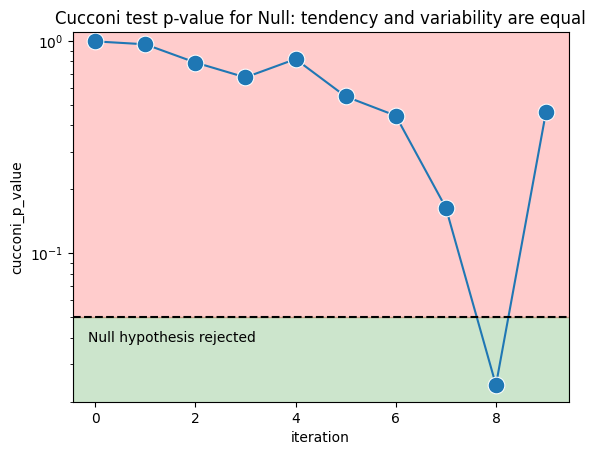

In [ ]:
fig, ax = plt.subplots()
sns.lineplot(data=df_ks, x="iteration", y="cucconi_p_value", markers=True, dashes=False, ax=ax, markersize=12, marker="o")
ax.axhline(0.05, color="black", ls="--")

# Draw a filled area below the 0.05 line without modifying the original plot's limits:
original_xlim = ax.get_xlim()
original_ylim = ax.get_ylim()
ax.fill_between(original_xlim, 0, 0.05, color="green", alpha=0.2)
ax.fill_between(original_xlim, 0.05, 10, color="red", alpha=0.2)
ax.set_xlim(original_xlim)
ax.set_ylim((0.02, 1.1))

# Text below 0.05 line saying that the null hypothesis is rejected:
ax.text(0.2, 0.04, "Null hypothesis rejected", horizontalalignment='center', verticalalignment='center', transform=ax.get_yaxis_transform(), color="black")
ax.set_yscale("log")
ax.set_title("Cucconi test p-value for Null: tendency and variability are equal")
plt.show()